This code was extracted from the following repository:
https://github.com/hklchung/GAN-GenerativeAdversarialNetwork

The DCGAN folder

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape, LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import plot_model
from keras import Input
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from sklearn.utils import shuffle
from PIL import Image
from keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Path

In [3]:
main_path = "/content/drive/MyDrive/plant_images/"
img_path = main_path + "original/aloevera/"
out_path = main_path + "resized/aloevera/"

A procedure that delete files in a folder

In [4]:
import os

def delete_files(folder_path):
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path) or os.path.islink(file_path):
          os.unlink(file_path)
      elif os.path.isdir(file_path):
          # If you also want to remove subdirectories, use: os.rmdir(file_path)
          pass


Delete old files

In [5]:
delete_files(main_path + 'generated_images/')
delete_files(main_path + 'trained_model/')

# Resize images

In [ ]:
# Already executed and saved, there is no need to re-run this code unless a changed is made to the size for example

# for filename in tqdm(os.listdir(img_path)):
#     temp = Image.open(img_path + '/' + filename)
#     size = 64, 64
#     temp.thumbnail(size, Image.LANCZOS)
#     temp.save(out_path + '/' + filename, "JPEG")

# Normalize Images

The RGB values of images, which are typically in the range [0, 255], are normalized to fall between 0 and 1. This processed data is saved in the X variable. The original list images is deleted to free up memory.

In [6]:
#============================Get images========================================
images = []
# Grab images from folder
for filename in tqdm(os.listdir(out_path)):
    temp = np.array(img_to_array(load_img(out_path + '/' + filename)), dtype=float)
    hor = 64 - temp.shape[0]
    ver = 64 - temp.shape[1]
    if hor%2 != 0:
        temp = np.pad(temp, ((hor//2 + 1, hor//2), (ver//2, ver//2), (0, 0)), mode='constant', constant_values=0)
    elif ver%2 != 0:
        temp = np.pad(temp, ((hor//2, hor//2), (ver//2 + 1, ver//2), (0, 0)), mode='constant', constant_values=0)
    else:
    # Pad resized images with zeros such that they are all 64x64x3
        temp = np.pad(temp, ((hor//2, hor//2), (ver//2, ver//2), (0, 0)), mode='constant', constant_values=0)
    # Store images into a list
    images.append(np.array(temp, dtype=float))

# Normalise RGB intensities, reshape and forced into array
X = [1.0/255*x for x in images]
X = [x.reshape(64, 64, 3) for x in X]
X = np.array(X)

del(images)

100%|██████████| 1000/1000 [00:11<00:00, 88.70it/s]


We need to install graphviz python linrary and graphviz system package for the plot_model function

In [7]:
!pip install pydot graphviz
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


# Define Generator Network

The generator is the "fraudster AI" that attempts to generate fake images to fool the discriminator. Its architecture is more complex than the discriminator and involves dense layers, reshaping, convolutional layers, and transposed convolutional layers.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              270336    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       1048832   
 anspose)                                                        
                                                        

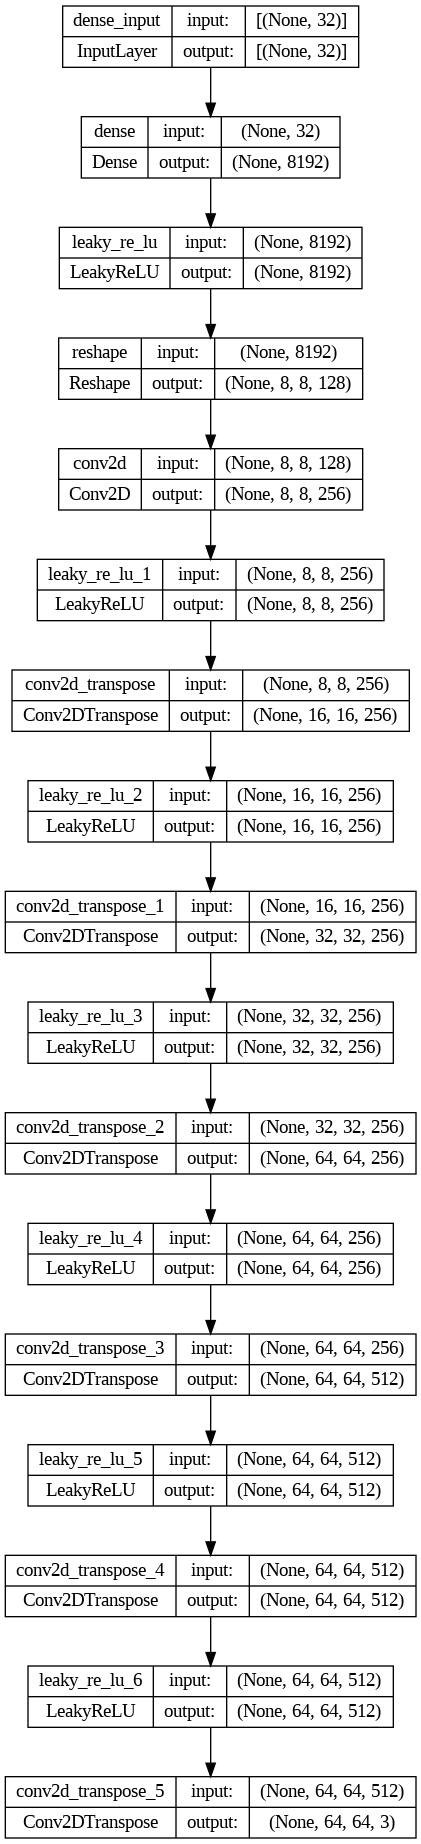

In [8]:
#==========================Generator model=====================================
# Define architecture of the generator (fraudster AI)
depth = 128
dim = 8
noise_vec = 32

G = Sequential()
# Input + First layer
G.add(Dense(dim*dim*depth, input_dim=noise_vec))
G.add(LeakyReLU())
G.add(Reshape((dim, dim, depth)))
# Second layer
G.add(Conv2D(depth*2, 5, padding = 'same'))
G.add(LeakyReLU())
# Third layer
G.add(Conv2DTranspose(depth*2, 4, strides=2, padding = 'same'))
G.add(LeakyReLU())
# Forth layer
G.add(Conv2DTranspose(depth*2, 4, strides=2, padding = 'same'))
G.add(LeakyReLU())
# Fifth layer
G.add(Conv2DTranspose(depth*2, 4, strides=2, padding = 'same'))
G.add(LeakyReLU())
# Sixth layer
G.add(Conv2DTranspose(depth*4, 5, strides=1, padding = 'same'))
G.add(LeakyReLU())
# Seventh layer
G.add(Conv2DTranspose(depth*4, 5, strides=1, padding = 'same'))
G.add(LeakyReLU())
# Output
G.add(Conv2DTranspose(3, 7, strides=1, activation = 'tanh', padding = 'same'))

# Print out architecture of the generator
G.summary()
# Save model architecture as .PNG
plot_model(G, to_file= main_path + 'model_plots/' + 'generator.png', show_shapes=True, show_layer_names=True)

# Define Discriminator Network

The discriminator is the "police AI" that tries to distinguish between real and fake images. Its architecture is sequential, with convolutional layers followed by activation functions.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 256)       7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 30, 30, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 14, 14, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 256)        

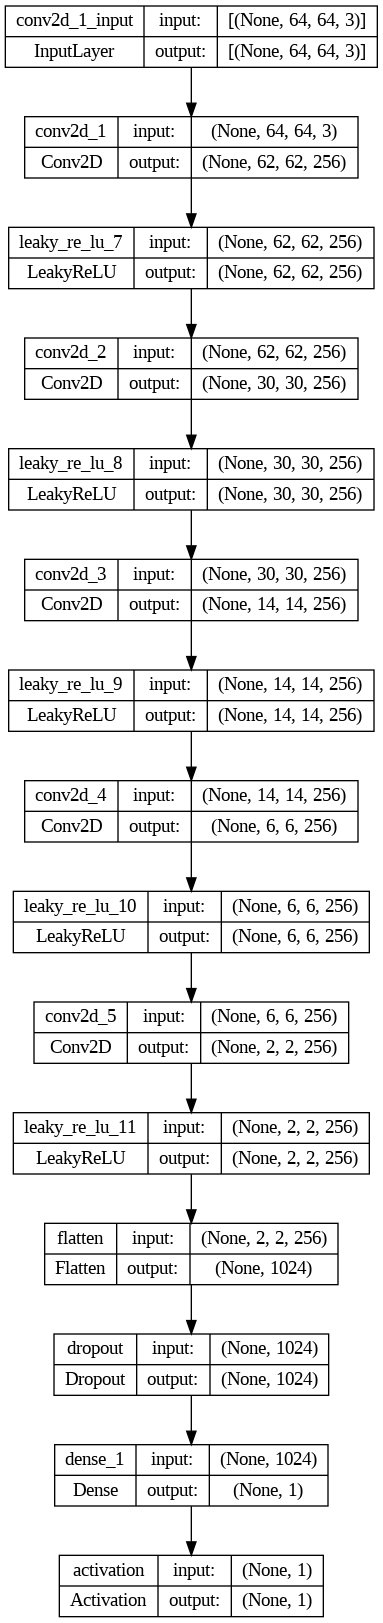

In [9]:
#=========================Discriminator model==================================
# Define architecture of the discriminator (police AI)
noise = 32
depth = 256

D = Sequential()
# Input + First layer
D.add(Conv2D(depth, 3, strides=1, input_shape=X.shape[1:]))
D.add(LeakyReLU())
# Second layer
D.add(Conv2D(depth, 4, strides=2))
D.add(LeakyReLU())
# Third layer
D.add(Conv2D(depth, 4, strides=2))
D.add(LeakyReLU())
# Forth layer
D.add(Conv2D(depth, 4, strides=2))
D.add(LeakyReLU())
# Fifth layer
D.add(Conv2D(depth, 4, strides=2))
D.add(LeakyReLU())
# Output
D.add(Flatten())
D.add(Dropout(0.4))
D.add(Dense(1))
D.add(Activation('sigmoid'))

# Print out architecture of the discriminator
D.summary()
# Save model architecture as .PNG
plot_model(D, to_file= main_path + 'model_plots/' + 'discriminator.png', show_shapes=True, show_layer_names=True)

# Define Optimizers

In [10]:
#================================DCGAN=========================================
# Define optimisers

# Define an exponential decay schedule for the learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)

# Try legacy optimizer
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=lr_schedule, clipvalue=1.0)

D.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
D.trainable = False

# Define GAN

The DCGAN is a combination of the generator and discriminator. Initially, the discriminator is made non-trainable. The generator generates an image, which is then fed to the discriminator to judge its authenticity.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         14142979  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4203521   
                                                                 
Total params: 18346500 (69.99 MB)
Trainable params: 14142979 (53.95 MB)
Non-trainable params: 4203521 (16.04 MB)
_________________________________________________________________


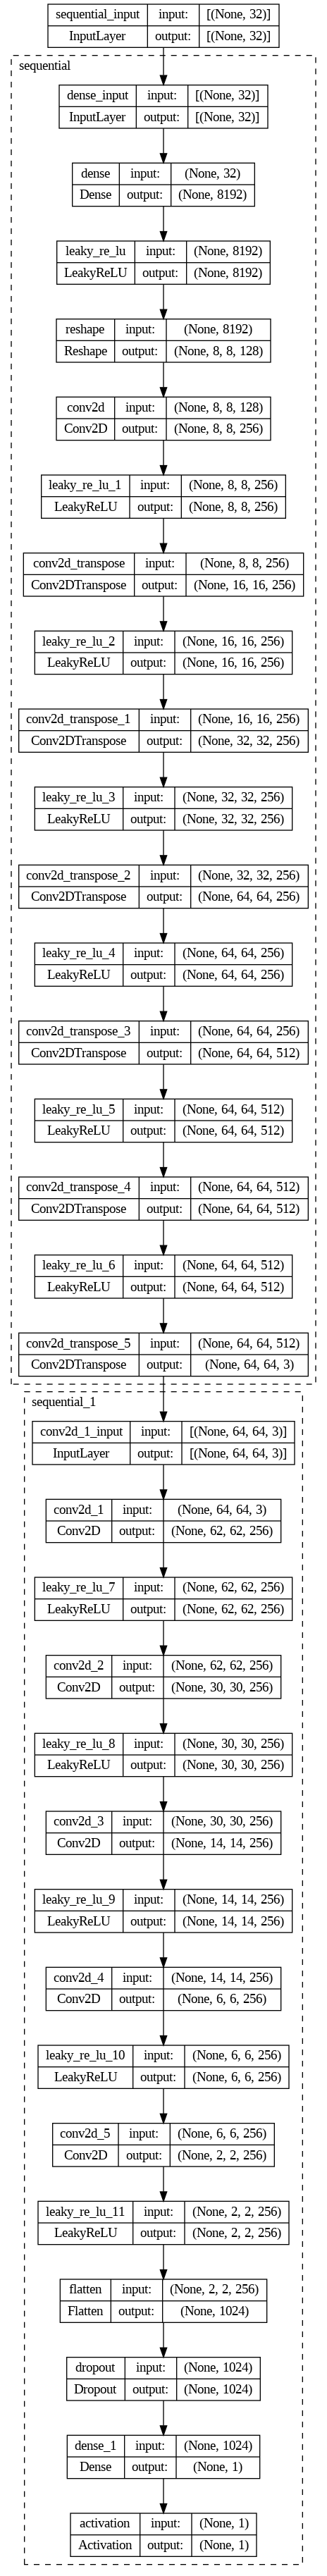

In [11]:
# Define architecture of DCGAN
GAN = Sequential()
GAN.add(G)  # Adding the generator
GAN.add(D)  # Adding the discriminator

# Compile DCGAN
GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

# Print out architecture of DCGAN
GAN.summary()
# Save model architecture as .PNG
plot_model(GAN, to_file= main_path + 'model_plots/' + 'DCGAN.png', show_shapes=True, show_layer_names=True)
plot_model(GAN, to_file= main_path + 'model_plots/' + 'DCGAN_expand.png', expand_nested=True, show_shapes=True, show_layer_names=True)

# Plot Image Function

plot_output is a function that takes noise as input, uses the generator to produce images, and saves a 4x4 grid of these images in a .png file.

In [12]:
#==========================Plot image function=================================
def plot_output(noise, step):
    filename = "GANmodel_%d.png" % step

    images = G.predict(noise)

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = image.reshape(images.shape[1], images.shape[2], images.shape[3])
        plt.imshow(image)w
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(main_path + 'generated_images/' + filename)
    plt.close('all')

# Plot Loss Function

plot_loss is a function to visualize the training losses of the discriminator and the GAN, plotting them against each other.

In [13]:
#==========================Plot loss function==================================
def plot_loss(d_performance, gan_performance, jump=100):
    plt.figure(figsize=(10, 10))
    plt.plot(d_performance[0::jump], label='discriminator')
    plt.plot(gan_performance[0::jump], label='GAN')
    plt.xlabel('iteration (Skipping every {}its)'.format(jump))
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(main_path + 'trained_model/' + 'loss_over_epoch.png')
    plt.close('all')

# Train GAN Code

train_gan is the primary function to train the DCGAN. The discriminator is trained first to distinguish between real and fake images. The GAN (with the generator) is then trained to generate images to fool the discriminator.

In [31]:
#=========================Train GAN function===================================
def train_gan(X, batch_size, epoch, save_interval, noise_len=32):
    d_losses = []
    gan_losses = []

    batch_per_epoch = int(round(X.shape[0]/batch_size))

    for i in range(epoch):
        start = 0
        for j in tqdm(range(batch_per_epoch)):
            #=====================Train discriminator==========================
            noise_vec = np.random.normal(size=(batch_size, noise))
            images_fake = G.predict(noise_vec)

            images_real = X[start:start + batch_size]
            x = np.concatenate([images_fake, images_real])

            y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
            y += .05 * np.random.random(y.shape)

            d_loss = D.train_on_batch(x, y)
            d_losses.append(d_loss[0])

            #=========================Train GAN================================
            noise_vec = np.random.normal(size=(batch_size, noise))
            y = np.zeros((batch_size, 1))

            gan_loss = GAN.train_on_batch(noise_vec, y)
            gan_losses.append(gan_loss)

            start += batch_size
            if start > X.shape[0] - batch_size:
                start = 0
        # Print loss and accuracy values
        log_msg = "epoch %d: [D loss: %f]" % (i, d_loss[0])
        log_msg = "%s  [GAN loss: %f]" % (log_msg, gan_loss)
        print(log_msg)

        # Save ouputs
        if save_interval>0 and (i+1)%save_interval==0:
            noise_input = np.random.normal(0.0, 1.0, size=[16, noise_len])
            plot_output(noise=noise_input, step=(i+1))

        # Save weights every 5 epochs
        if (i+1) % 5 == 0:
            GAN.save_weights(main_path + 'trained_model/' + "GAN_weights_epoch_" + str(i+1) + ".keras", overwrite=True)
            D.save_weights(main_path + 'trained_model/' + "D_weights_epoch_" + str(i+1) + ".keras", overwrite=True)
            G.save_weights(main_path + 'trained_model/' + "G_weights_epoch_" + str(i+1) + ".keras", overwrite=True)
            print (f"New weights are saved after epoch number: {i}")

    d_losses = [float(x) for x in d_losses]
    gan_losses = [float(x) for x in gan_losses]

    return(d_losses, gan_losses)

# Start Training the GAN
This part invokes the train_gan function to train the model for 50 epochs.



In [15]:
#=================================Train GAN====================================
d_loss_ls, gan_loss_ls = train_gan(X=X, batch_size=16, epoch=50,
                                                         save_interval=1,
                                                         noise_len=32)

plot_loss(d_loss_ls, gan_loss_ls)

  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


  2%|▏         | 1/62 [00:39<39:43, 39.07s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/62 [00:39<16:21, 16.36s/it]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:40<08:57,  9.10s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:40<05:31,  5.71s/it]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:40<03:37,  3.82s/it]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 6/62 [00:41<02:31,  2.71s/it]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 7/62 [00:42<01:51,  2.03s/it]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 8/62 [00:42<01:25,  1.59s/it]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 9/62 [00:43<01:09,  1.31s/it]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 10/62 [00:44<00:58,  1.12s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 11/62 [00:44<00:48,  1.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 12/62 [00:45<00:40,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 13/62 [00:45<00:35,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:46<00:31,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 15/62 [00:46<00:27,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 16/62 [00:47<00:25,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:47<00:23,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 18/62 [00:48<00:23,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 19/62 [00:48<00:21,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 20/62 [00:49<00:20,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 21/62 [00:49<00:20,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 22/62 [00:50<00:19,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 23/62 [00:50<00:20,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 24/62 [00:51<00:19,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:51<00:18,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:52<00:17,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 27/62 [00:52<00:16,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:53<00:16,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:53<00:16,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 30/62 [00:54<00:15,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:54<00:15,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 32/62 [00:55<00:15,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 33/62 [00:55<00:15,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:56<00:15,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 35/62 [00:56<00:15,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 36/62 [00:57<00:14,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 37/62 [00:58<00:14,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 38/62 [00:58<00:13,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:59<00:12,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:59<00:11,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 41/62 [01:00<00:10,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 42/62 [01:00<00:09,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 43/62 [01:01<00:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 44/62 [01:01<00:09,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [01:02<00:08,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 46/62 [01:02<00:08,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [01:03<00:07,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 48/62 [01:03<00:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 49/62 [01:04<00:06,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 50/62 [01:04<00:06,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 51/62 [01:05<00:06,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [01:05<00:05,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 53/62 [01:06<00:04,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 54/62 [01:06<00:04,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 55/62 [01:07<00:03,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [01:07<00:03,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 57/62 [01:08<00:02,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 58/62 [01:08<00:02,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 59/62 [01:09<00:01,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 60/62 [01:10<00:01,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 61/62 [01:10<00:00,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 62/62 [01:11<00:00,  1.15s/it]

epoch 0: [D loss: 0.620189]  [GAN loss: 0.655829]
1/1 [==============================] - 0s 28ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:29,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 2/62 [00:00<00:29,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 3/62 [00:01<00:28,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 4/62 [00:01<00:28,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:02<00:27,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:02<00:27,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 7/62 [00:03<00:27,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:03<00:26,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 9/62 [00:04<00:26,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:04<00:26,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 11/62 [00:05<00:25,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:05<00:25,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 13/62 [00:06<00:24,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:06<00:23,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:07<00:23,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:07<00:22,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 17/62 [00:08<00:22,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:08<00:21,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:09<00:21,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:09<00:21,  1.98it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 21/62 [00:10<00:22,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 22/62 [00:11<00:23,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 23/62 [00:11<00:22,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 24/62 [00:12<00:22,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 25/62 [00:13<00:22,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 26/62 [00:13<00:21,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:14<00:20,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:14<00:19,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:15<00:18,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 30/62 [00:15<00:16,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:16<00:15,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:17<00:14,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:18<00:14,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 36/62 [00:18<00:13,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 37/62 [00:19<00:13,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 39/62 [00:20<00:12,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:21<00:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 43/62 [00:22<00:09,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:23<00:08,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 47/62 [00:24<00:08,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 48/62 [00:25<00:08,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 50/62 [00:26<00:07,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 51/62 [00:27<00:06,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:27<00:05,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:28<00:05,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:28<00:04,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:29<00:03,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 58/62 [00:30<00:02,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 60/62 [00:31<00:01,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 62/62 [00:32<00:00,  1.88it/s]

epoch 1: [D loss: 0.552627]  [GAN loss: 0.873755]
1/1 [==============================] - 0s 18ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 9/62 [00:04<00:29,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 10/62 [00:05<00:30,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 12/62 [00:06<00:31,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 13/62 [00:07<00:29,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:07<00:27,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 19/62 [00:10<00:22,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 24/62 [00:13<00:19,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 25/62 [00:13<00:19,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 26/62 [00:14<00:18,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 27/62 [00:14<00:19,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 33/62 [00:17<00:16,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 35/62 [00:19<00:15,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 37/62 [00:20<00:15,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 38/62 [00:20<00:14,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 40/62 [00:21<00:12,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:24<00:08,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 46/62 [00:24<00:07,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 48/62 [00:25<00:06,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 50/62 [00:26<00:06,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:27<00:05,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 54/62 [00:28<00:03,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 56/62 [00:29<00:02,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 58/62 [00:30<00:01,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.83it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 62/62 [00:33<00:00,  1.86it/s]

epoch 2: [D loss: 0.537947]  [GAN loss: 1.205873]
1/1 [==============================] - 0s 30ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 1/62 [00:00<00:29,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/62 [00:00<00:29,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 4/62 [00:02<00:31,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:27,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 9/62 [00:04<00:26,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 10/62 [00:05<00:25,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:05<00:25,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 12/62 [00:06<00:24,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 13/62 [00:06<00:24,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:07<00:23,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:07<00:23,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 16/62 [00:08<00:22,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:08<00:22,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 18/62 [00:08<00:21,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 19/62 [00:09<00:21,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 21/62 [00:10<00:23,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 22/62 [00:11<00:23,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 23/62 [00:11<00:22,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 24/62 [00:12<00:22,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 25/62 [00:13<00:22,  1.65it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 26/62 [00:13<00:21,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 27/62 [00:14<00:20,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 28/62 [00:14<00:20,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 29/62 [00:15<00:18,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:15<00:17,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 32/62 [00:16<00:15,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:18<00:13,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 37/62 [00:19<00:12,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:19<00:11,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 39/62 [00:20<00:11,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 40/62 [00:20<00:10,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:21<00:10,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 42/62 [00:21<00:09,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:22<00:09,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 44/62 [00:22<00:08,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:23<00:08,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 47/62 [00:24<00:08,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 49/62 [00:25<00:07,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 50/62 [00:26<00:07,  1.68it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 51/62 [00:27<00:06,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 52/62 [00:27<00:05,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:28<00:05,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:28<00:04,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 56/62 [00:29<00:03,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:30<00:02,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 60/62 [00:31<00:01,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 62/62 [00:32<00:00,  1.90it/s]

epoch 3: [D loss: 0.423577]  [GAN loss: 2.011347]
1/1 [==============================] - 0s 29ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:29,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:02<00:28,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 8/62 [00:04<00:27,  1.93it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 9/62 [00:04<00:27,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 11/62 [00:05<00:29,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 12/62 [00:06<00:29,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 13/62 [00:07<00:30,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 14/62 [00:07<00:28,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 19/62 [00:10<00:22,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:11<00:20,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:12<00:19,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 24/62 [00:12<00:19,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:13<00:18,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 26/62 [00:13<00:18,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:14<00:17,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 29/62 [00:15<00:16,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 30/62 [00:15<00:16,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:16<00:15,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:16<00:15,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 35/62 [00:18<00:15,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 37/62 [00:19<00:14,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 38/62 [00:20<00:14,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:21<00:12,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:24<00:08,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 50/62 [00:26<00:06,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:27<00:05,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:28<00:04,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 56/62 [00:29<00:03,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 58/62 [00:30<00:02,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.73it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 62/62 [00:33<00:00,  1.86it/s]

epoch 4: [D loss: 0.491522]  [GAN loss: 1.224455]
1/1 [==============================] - 0s 29ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 1/62 [00:00<00:38,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/62 [00:01<00:33,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 8/62 [00:04<00:27,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 9/62 [00:04<00:26,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:05<00:26,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:05<00:25,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 12/62 [00:06<00:25,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 13/62 [00:06<00:25,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:07<00:24,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:07<00:23,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:23,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:08<00:23,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 18/62 [00:09<00:22,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:09<00:22,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 21/62 [00:10<00:20,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 22/62 [00:11<00:22,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 23/62 [00:12<00:22,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 24/62 [00:12<00:21,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 25/62 [00:13<00:21,  1.71it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 26/62 [00:13<00:21,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 27/62 [00:14<00:20,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:14<00:18,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 30/62 [00:15<00:16,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:16<00:15,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:17<00:14,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 34/62 [00:17<00:14,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:18<00:13,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 37/62 [00:19<00:12,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 39/62 [00:20<00:11,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:21<00:11,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 43/62 [00:22<00:09,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:23<00:08,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 47/62 [00:24<00:07,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 49/62 [00:25<00:07,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 50/62 [00:26<00:06,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 51/62 [00:27<00:06,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 52/62 [00:27<00:05,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 53/62 [00:28<00:05,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 54/62 [00:28<00:04,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:29<00:03,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 58/62 [00:30<00:02,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 60/62 [00:31<00:01,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:32<00:00,  1.88it/s]

epoch 5: [D loss: 0.418716]  [GAN loss: 1.381421]
1/1 [==============================] - 0s 18ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:29,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/62 [00:00<00:30,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 5/62 [00:02<00:28,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 7/62 [00:03<00:27,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:30,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 10/62 [00:05<00:29,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 11/62 [00:06<00:30,  1.68it/s]

1/1 [==============================] - 0s 68ms/step


 19%|█▉        | 12/62 [00:06<00:29,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 13/62 [00:07<00:29,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 14/62 [00:07<00:28,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.71it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 16/62 [00:09<00:28,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 17/62 [00:09<00:28,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 18/62 [00:10<00:26,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 19/62 [00:10<00:26,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 20/62 [00:11<00:25,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 21/62 [00:11<00:23,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 24/62 [00:13<00:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 25/62 [00:13<00:19,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 27/62 [00:15<00:18,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:17<00:15,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:19<00:13,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 38/62 [00:20<00:13,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 40/62 [00:22<00:13,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 41/62 [00:22<00:13,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 42/62 [00:23<00:12,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:23<00:11,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:27<00:06,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:28<00:05,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 56/62 [00:30<00:03,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 62/62 [00:33<00:00,  1.82it/s]

epoch 6: [D loss: 0.602503]  [GAN loss: 1.599805]
1/1 [==============================] - 0s 29ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 1/62 [00:00<00:39,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 2/62 [00:01<00:36,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 3/62 [00:01<00:33,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 4/62 [00:02<00:32,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 8/62 [00:04<00:27,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 9/62 [00:04<00:26,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 10/62 [00:05<00:26,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 11/62 [00:05<00:25,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 13/62 [00:06<00:25,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:07<00:24,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:07<00:23,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:23,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:08<00:22,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:09<00:21,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 19/62 [00:09<00:21,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:10<00:21,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 23/62 [00:12<00:21,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 24/62 [00:12<00:21,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 25/62 [00:13<00:20,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 26/62 [00:13<00:21,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 27/62 [00:14<00:21,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 28/62 [00:15<00:20,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 29/62 [00:15<00:18,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:18<00:14,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 37/62 [00:19<00:13,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 39/62 [00:20<00:11,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 41/62 [00:21<00:10,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 43/62 [00:22<00:09,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:23<00:08,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 47/62 [00:24<00:07,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 50/62 [00:26<00:06,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 51/62 [00:27<00:06,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 52/62 [00:27<00:05,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 53/62 [00:28<00:05,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:33<00:00,  1.87it/s]

epoch 7: [D loss: 0.328630]  [GAN loss: 2.077156]
1/1 [==============================] - 0s 24ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:01<00:31,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/62 [00:01<00:29,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 5/62 [00:02<00:28,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 7/62 [00:03<00:27,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 8/62 [00:04<00:26,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 9/62 [00:04<00:26,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 11/62 [00:05<00:28,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 12/62 [00:06<00:29,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 13/62 [00:07<00:29,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 14/62 [00:07<00:30,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 19/62 [00:10<00:23,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 20/62 [00:10<00:22,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 23/62 [00:12<00:19,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 24/62 [00:12<00:19,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 25/62 [00:13<00:19,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 26/62 [00:13<00:18,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 28/62 [00:14<00:17,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 29/62 [00:15<00:16,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:15<00:16,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:16<00:15,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 32/62 [00:16<00:15,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:17<00:14,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 35/62 [00:18<00:14,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 37/62 [00:19<00:14,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 38/62 [00:20<00:14,  1.70it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 40/62 [00:21<00:12,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 45/62 [00:24<00:08,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 50/62 [00:26<00:06,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:27<00:05,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:28<00:04,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 56/62 [00:29<00:02,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 58/62 [00:30<00:02,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 60/62 [00:31<00:01,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 62/62 [00:32<00:00,  1.88it/s]

epoch 8: [D loss: 0.323978]  [GAN loss: 1.803878]
1/1 [==============================] - 0s 28ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 1/62 [00:00<00:42,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/62 [00:01<00:37,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 3/62 [00:01<00:33,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 4/62 [00:02<00:31,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 7/62 [00:03<00:27,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 8/62 [00:04<00:27,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 9/62 [00:04<00:26,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 10/62 [00:05<00:26,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 11/62 [00:05<00:25,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:06<00:24,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 13/62 [00:06<00:24,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:07<00:23,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 15/62 [00:07<00:23,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 16/62 [00:08<00:22,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:08<00:22,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 18/62 [00:09<00:22,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 19/62 [00:09<00:22,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 20/62 [00:10<00:22,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:10<00:21,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 23/62 [00:11<00:20,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 24/62 [00:12<00:21,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 25/62 [00:13<00:21,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 26/62 [00:13<00:21,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 27/62 [00:14<00:20,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 28/62 [00:14<00:19,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:15<00:18,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:15<00:17,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:16<00:16,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 33/62 [00:17<00:16,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 35/62 [00:18<00:14,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 37/62 [00:19<00:12,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:20<00:12,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 41/62 [00:21<00:10,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 43/62 [00:22<00:09,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:23<00:08,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 47/62 [00:24<00:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 49/62 [00:25<00:07,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 50/62 [00:26<00:07,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 51/62 [00:27<00:06,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 52/62 [00:27<00:06,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 53/62 [00:28<00:05,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 54/62 [00:28<00:04,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 55/62 [00:29<00:04,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 62/62 [00:33<00:00,  1.87it/s]

epoch 9: [D loss: 0.378078]  [GAN loss: 1.784593]
1/1 [==============================] - 0s 19ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:00<00:29,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 7/62 [00:03<00:27,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 8/62 [00:04<00:27,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 11/62 [00:05<00:28,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 12/62 [00:06<00:28,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 13/62 [00:07<00:29,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 14/62 [00:07<00:29,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 15/62 [00:08<00:28,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:08<00:26,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 19/62 [00:10<00:22,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 24/62 [00:12<00:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 25/62 [00:13<00:18,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 26/62 [00:13<00:19,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 35/62 [00:18<00:14,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 37/62 [00:19<00:14,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 38/62 [00:20<00:14,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 40/62 [00:21<00:13,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 41/62 [00:22<00:12,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 42/62 [00:22<00:11,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 62/62 [00:33<00:00,  1.85it/s]

epoch 10: [D loss: 0.358673]  [GAN loss: 1.947154]
1/1 [==============================] - 0s 45ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 1/62 [00:00<00:33,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 2/62 [00:01<00:33,  1.81it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 3/62 [00:01<00:33,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:31,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:27,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:26,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 10/62 [00:05<00:26,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:05<00:26,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:06<00:25,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 13/62 [00:06<00:25,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:07<00:24,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 15/62 [00:07<00:23,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 16/62 [00:08<00:23,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:08<00:22,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:09<00:22,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:09<00:21,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:10<00:20,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 23/62 [00:11<00:20,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 24/62 [00:12<00:26,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 25/62 [00:13<00:25,  1.46it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 26/62 [00:14<00:24,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 27/62 [00:14<00:23,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 28/62 [00:15<00:22,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 29/62 [00:16<00:19,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 30/62 [00:16<00:18,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 31/62 [00:17<00:17,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 41/62 [00:22<00:10,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 47/62 [00:25<00:08,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 50/62 [00:27<00:07,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 51/62 [00:28<00:07,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 52/62 [00:28<00:06,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:29<00:05,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.87it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:34<00:00,  1.82it/s]

epoch 11: [D loss: 0.415139]  [GAN loss: 1.945682]
1/1 [==============================] - 0s 18ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:29,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:00<00:29,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 3/62 [00:01<00:29,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 5/62 [00:02<00:31,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 8/62 [00:04<00:31,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 9/62 [00:05<00:32,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 10/62 [00:05<00:31,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 12/62 [00:06<00:29,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 13/62 [00:07<00:29,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:07<00:27,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:09<00:25,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:10<00:22,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:11<00:21,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:20,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 23/62 [00:12<00:19,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 24/62 [00:13<00:19,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:13<00:19,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 26/62 [00:14<00:18,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:14<00:17,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:16<00:15,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 34/62 [00:18<00:16,  1.71it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 35/62 [00:18<00:15,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 37/62 [00:20<00:14,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 38/62 [00:20<00:14,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:21<00:12,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 50/62 [00:26<00:06,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 62/62 [00:33<00:00,  1.84it/s]

epoch 12: [D loss: 0.383669]  [GAN loss: 1.979064]
1/1 [==============================] - 0s 27ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 1/62 [00:00<00:35,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/62 [00:01<00:31,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 6/62 [00:03<00:28,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:27,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 9/62 [00:04<00:27,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 10/62 [00:05<00:26,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:05<00:25,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 13/62 [00:06<00:25,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 15/62 [00:07<00:25,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:08<00:24,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:09<00:22,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:10<00:22,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.86it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 22/62 [00:11<00:21,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 23/62 [00:12<00:23,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 24/62 [00:12<00:23,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 25/62 [00:13<00:23,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 26/62 [00:14<00:22,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 27/62 [00:14<00:20,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:19,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:15<00:18,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 35/62 [00:18<00:13,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 37/62 [00:19<00:12,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:20<00:11,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 41/62 [00:21<00:10,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 47/62 [00:25<00:08,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 49/62 [00:26<00:08,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 50/62 [00:27<00:07,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 51/62 [00:27<00:06,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:33<00:00,  1.86it/s]

epoch 13: [D loss: 0.377660]  [GAN loss: 1.697155]
1/1 [==============================] - 0s 18ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 1/62 [00:00<00:34,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 7/62 [00:03<00:31,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 8/62 [00:04<00:30,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 9/62 [00:04<00:30,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 10/62 [00:05<00:29,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 11/62 [00:06<00:30,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 12/62 [00:06<00:30,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 13/62 [00:07<00:28,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:09<00:23,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:09<00:22,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 19/62 [00:10<00:22,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:11<00:20,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 25/62 [00:13<00:19,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 26/62 [00:14<00:18,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 29/62 [00:15<00:16,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:16<00:15,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:18<00:16,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 36/62 [00:19<00:15,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 37/62 [00:20<00:14,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 38/62 [00:20<00:14,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:21<00:12,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:24<00:08,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 62/62 [00:34<00:00,  1.82it/s]

epoch 14: [D loss: 0.404955]  [GAN loss: 1.543445]
1/1 [==============================] - 0s 34ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:32,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 11/62 [00:05<00:26,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 13/62 [00:06<00:25,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:07<00:24,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:07<00:23,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:23,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 17/62 [00:08<00:22,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:09<00:22,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 19/62 [00:09<00:21,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 20/62 [00:10<00:23,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 21/62 [00:11<00:23,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 22/62 [00:11<00:23,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 23/62 [00:12<00:23,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 24/62 [00:12<00:22,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 25/62 [00:13<00:22,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 26/62 [00:14<00:20,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 27/62 [00:14<00:19,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 33/62 [00:17<00:14,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 35/62 [00:18<00:14,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 37/62 [00:19<00:13,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 39/62 [00:20<00:12,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 41/62 [00:21<00:11,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 43/62 [00:22<00:09,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 46/62 [00:24<00:08,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 47/62 [00:25<00:08,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 51/62 [00:27<00:06,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:28<00:05,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:33<00:00,  1.86it/s]

epoch 15: [D loss: 0.385875]  [GAN loss: 1.693075]
1/1 [==============================] - 0s 19ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 3/62 [00:01<00:29,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 9/62 [00:04<00:31,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 10/62 [00:05<00:32,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 12/62 [00:06<00:31,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 13/62 [00:07<00:31,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:08<00:28,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 17/62 [00:09<00:23,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:10<00:23,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:10<00:22,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:11<00:21,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 22/62 [00:12<00:20,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 23/62 [00:12<00:19,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 25/62 [00:13<00:19,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 33/62 [00:18<00:16,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 34/62 [00:18<00:16,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 36/62 [00:19<00:15,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 37/62 [00:20<00:14,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 38/62 [00:21<00:14,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:23<00:10,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:24<00:08,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 62/62 [00:34<00:00,  1.80it/s]

epoch 16: [D loss: 0.382710]  [GAN loss: 2.032196]
1/1 [==============================] - 0s 33ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 1/62 [00:00<00:38,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 2/62 [00:01<00:40,  1.50it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 3/62 [00:01<00:38,  1.53it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▋         | 4/62 [00:02<00:35,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 5/62 [00:03<00:35,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 6/62 [00:03<00:33,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 7/62 [00:04<00:31,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 9/62 [00:05<00:28,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 11/62 [00:06<00:26,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 12/62 [00:06<00:25,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 13/62 [00:07<00:25,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 15/62 [00:08<00:24,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 19/62 [00:10<00:24,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 20/62 [00:11<00:25,  1.67it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 21/62 [00:11<00:25,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 22/62 [00:12<00:25,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 23/62 [00:13<00:23,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:14<00:20,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:15<00:18,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:17<00:15,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 35/62 [00:19<00:13,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 37/62 [00:20<00:12,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:21<00:11,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:22<00:10,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 47/62 [00:25<00:08,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:33<00:00,  1.84it/s]

epoch 17: [D loss: 0.405210]  [GAN loss: 1.755446]
1/1 [==============================] - 0s 20ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:29,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 5/62 [00:02<00:33,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 6/62 [00:03<00:32,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 7/62 [00:04<00:34,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 8/62 [00:04<00:33,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 9/62 [00:05<00:33,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 10/62 [00:05<00:32,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 11/62 [00:06<00:29,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:06<00:28,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 13/62 [00:07<00:26,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:24,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 16/62 [00:08<00:23,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:09<00:23,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 18/62 [00:09<00:22,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 19/62 [00:10<00:21,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 21/62 [00:11<00:20,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 24/62 [00:13<00:19,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:13<00:18,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:18,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 27/62 [00:14<00:17,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 31/62 [00:16<00:17,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 32/62 [00:17<00:17,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 33/62 [00:18<00:18,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:18<00:17,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 36/62 [00:19<00:15,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 37/62 [00:20<00:14,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:20<00:13,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 41/62 [00:22<00:10,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 45/62 [00:24<00:08,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 57/62 [00:31<00:03,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:34<00:00,  1.82it/s]

epoch 18: [D loss: 0.361991]  [GAN loss: 1.788014]
1/1 [==============================] - 0s 24ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:31,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 6/62 [00:03<00:28,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 7/62 [00:03<00:27,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:27,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 10/62 [00:05<00:26,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:05<00:26,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 13/62 [00:06<00:25,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 15/62 [00:07<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:08<00:24,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 18/62 [00:09<00:26,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 19/62 [00:10<00:25,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 20/62 [00:10<00:25,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 21/62 [00:11<00:26,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 22/62 [00:12<00:25,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:12<00:22,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:13<00:20,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:14<00:19,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:17<00:14,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:18<00:13,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 37/62 [00:19<00:12,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 39/62 [00:20<00:11,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 41/62 [00:21<00:10,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 44/62 [00:23<00:10,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 46/62 [00:24<00:09,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 47/62 [00:25<00:08,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 48/62 [00:25<00:07,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:26<00:06,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 62/62 [00:33<00:00,  1.87it/s]

epoch 19: [D loss: 0.279293]  [GAN loss: 2.055211]
1/1 [==============================] - 0s 20ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:33,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 5/62 [00:02<00:31,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 6/62 [00:03<00:31,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 7/62 [00:03<00:31,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 8/62 [00:04<00:32,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 9/62 [00:05<00:32,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 10/62 [00:05<00:30,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 11/62 [00:06<00:29,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:06<00:28,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 13/62 [00:07<00:26,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 17/62 [00:09<00:23,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 18/62 [00:09<00:22,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 19/62 [00:10<00:22,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:11<00:20,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 22/62 [00:12<00:20,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 23/62 [00:12<00:19,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 24/62 [00:13<00:19,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 25/62 [00:13<00:18,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 26/62 [00:14<00:18,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 27/62 [00:14<00:17,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 29/62 [00:15<00:16,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 31/62 [00:16<00:17,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 32/62 [00:17<00:18,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:18<00:16,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 37/62 [00:20<00:14,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:20<00:13,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.84it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:33<00:00,  1.83it/s]

epoch 20: [D loss: 0.345891]  [GAN loss: 1.913649]
1/1 [==============================] - 0s 28ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 3/62 [00:01<00:29,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 4/62 [00:02<00:29,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:02<00:28,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:28,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:27,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:26,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:26,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 11/62 [00:05<00:26,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:06<00:25,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 13/62 [00:06<00:24,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:07<00:24,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:07<00:24,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:08<00:25,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 18/62 [00:09<00:24,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 19/62 [00:10<00:24,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 20/62 [00:10<00:24,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 21/62 [00:11<00:24,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 22/62 [00:11<00:24,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 23/62 [00:12<00:23,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 24/62 [00:12<00:21,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:13<00:20,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 26/62 [00:13<00:19,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:14<00:17,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:15<00:16,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 30/62 [00:15<00:16,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:16<00:15,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:16<00:15,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 35/62 [00:18<00:15,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 37/62 [00:19<00:13,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 39/62 [00:20<00:12,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 41/62 [00:21<00:10,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 43/62 [00:22<00:10,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 44/62 [00:23<00:09,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 45/62 [00:24<00:10,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 46/62 [00:24<00:09,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 47/62 [00:25<00:09,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 57/62 [00:30<00:02,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 58/62 [00:31<00:02,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 59/62 [00:31<00:01,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 60/62 [00:32<00:01,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 61/62 [00:32<00:00,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:33<00:00,  1.86it/s]

epoch 21: [D loss: 0.328073]  [GAN loss: 1.735283]
1/1 [==============================] - 0s 21ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 5/62 [00:02<00:31,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 6/62 [00:03<00:33,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 7/62 [00:03<00:33,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 8/62 [00:04<00:34,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 9/62 [00:05<00:33,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 10/62 [00:05<00:31,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 11/62 [00:06<00:29,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:06<00:27,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 13/62 [00:07<00:26,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:24,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 16/62 [00:08<00:23,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 17/62 [00:09<00:23,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 19/62 [00:10<00:23,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:11<00:22,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:13<00:19,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 27/62 [00:14<00:19,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 31/62 [00:17<00:18,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 32/62 [00:17<00:17,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 34/62 [00:18<00:16,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 40/62 [00:22<00:11,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 42/62 [00:23<00:10,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:23<00:09,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:24<00:08,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:28<00:04,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 55/62 [00:29<00:03,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 57/62 [00:31<00:03,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.61it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 62/62 [00:34<00:00,  1.82it/s]

epoch 22: [D loss: 0.343491]  [GAN loss: 1.985552]
1/1 [==============================] - 0s 19ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 1/62 [00:00<00:30,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 9/62 [00:04<00:27,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 11/62 [00:05<00:28,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 13/62 [00:06<00:25,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 15/62 [00:07<00:25,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 16/62 [00:08<00:26,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 17/62 [00:09<00:26,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 18/62 [00:09<00:27,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 19/62 [00:10<00:26,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 20/62 [00:11<00:26,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 21/62 [00:11<00:26,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 22/62 [00:12<00:24,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 23/62 [00:12<00:22,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:14<00:20,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 27/62 [00:15<00:18,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:17<00:15,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:18<00:14,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:20<00:13,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 45/62 [00:24<00:10,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:26<00:09,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:34<00:00,  1.82it/s]

epoch 23: [D loss: 0.311474]  [GAN loss: 2.010927]
1/1 [==============================] - 0s 21ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 1/62 [00:00<00:30,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 3/62 [00:01<00:34,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▋         | 4/62 [00:02<00:33,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 5/62 [00:02<00:31,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 6/62 [00:03<00:32,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 7/62 [00:04<00:32,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 8/62 [00:04<00:31,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 9/62 [00:05<00:29,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:05<00:29,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 12/62 [00:06<00:28,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 13/62 [00:07<00:26,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 15/62 [00:08<00:24,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 16/62 [00:08<00:23,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:09<00:22,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 19/62 [00:10<00:23,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 20/62 [00:10<00:21,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 22/62 [00:11<00:20,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 23/62 [00:12<00:19,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 24/62 [00:12<00:19,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:13<00:18,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 26/62 [00:13<00:18,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 27/62 [00:14<00:17,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 31/62 [00:16<00:17,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 32/62 [00:17<00:18,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 33/62 [00:18<00:18,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 34/62 [00:18<00:16,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:19<00:15,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 40/62 [00:21<00:11,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 42/62 [00:22<00:10,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:25<00:08,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 49/62 [00:26<00:07,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.91it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 53/62 [00:29<00:05,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 55/62 [00:30<00:04,  1.72it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 57/62 [00:31<00:03,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 62/62 [00:34<00:00,  1.81it/s]

epoch 24: [D loss: 0.331964]  [GAN loss: 2.140199]
1/1 [==============================] - 0s 26ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 1/62 [00:00<00:30,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:32,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 11/62 [00:05<00:26,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 12/62 [00:06<00:25,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 13/62 [00:06<00:24,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:07<00:24,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 15/62 [00:07<00:25,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 17/62 [00:09<00:26,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 18/62 [00:09<00:26,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 19/62 [00:10<00:26,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 20/62 [00:11<00:25,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:11<00:23,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:23,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 23/62 [00:12<00:21,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 25/62 [00:13<00:20,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:15<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:16<00:16,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 33/62 [00:17<00:15,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 36/62 [00:19<00:14,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 40/62 [00:21<00:12,  1.73it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 41/62 [00:22<00:12,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 43/62 [00:23<00:11,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 45/62 [00:24<00:10,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:34<00:00,  1.81it/s]

epoch 25: [D loss: 0.359027]  [GAN loss: 2.263036]
1/1 [==============================] - 0s 23ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 1/62 [00:00<00:34,  1.76it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 3/62 [00:01<00:34,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 4/62 [00:02<00:36,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 5/62 [00:03<00:34,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 6/62 [00:03<00:35,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 7/62 [00:04<00:32,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 8/62 [00:04<00:31,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:05<00:29,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:06<00:27,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:06<00:27,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 13/62 [00:07<00:27,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 15/62 [00:08<00:24,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:10<00:23,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 19/62 [00:10<00:23,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 20/62 [00:11<00:22,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 22/62 [00:12<00:20,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 24/62 [00:13<00:19,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 25/62 [00:13<00:18,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 27/62 [00:14<00:19,  1.75it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 28/62 [00:15<00:20,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 29/62 [00:16<00:19,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 30/62 [00:16<00:19,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 31/62 [00:17<00:19,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:18<00:18,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 33/62 [00:18<00:16,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 38/62 [00:21<00:12,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:21<00:11,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 40/62 [00:22<00:11,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:22<00:10,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 42/62 [00:23<00:10,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 47/62 [00:25<00:07,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 49/62 [00:26<00:06,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 51/62 [00:27<00:05,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 53/62 [00:29<00:05,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 54/62 [00:29<00:04,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 55/62 [00:30<00:04,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 56/62 [00:30<00:03,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 57/62 [00:31<00:03,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:34<00:00,  1.82it/s]

epoch 26: [D loss: 0.288122]  [GAN loss: 2.133338]
1/1 [==============================] - 0s 24ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:32,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:05<00:26,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 13/62 [00:07<00:27,  1.75it/s]

1/1 [==============================] - 0s 61ms/step


 23%|██▎       | 14/62 [00:07<00:28,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 15/62 [00:08<00:28,  1.62it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 16/62 [00:09<00:28,  1.61it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 17/62 [00:09<00:29,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 18/62 [00:10<00:27,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 19/62 [00:10<00:27,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 20/62 [00:11<00:27,  1.53it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 21/62 [00:12<00:27,  1.51it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 22/62 [00:13<00:27,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 23/62 [00:13<00:24,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 24/62 [00:14<00:23,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:14<00:22,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:15<00:20,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 28/62 [00:16<00:18,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 30/62 [00:17<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 32/62 [00:18<00:16,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 33/62 [00:19<00:16,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:20<00:15,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 37/62 [00:21<00:13,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 38/62 [00:21<00:12,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 39/62 [00:22<00:12,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:22<00:11,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.77it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 42/62 [00:24<00:11,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 44/62 [00:25<00:10,  1.65it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 45/62 [00:25<00:10,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 46/62 [00:26<00:10,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 47/62 [00:27<00:09,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 48/62 [00:27<00:08,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 49/62 [00:28<00:07,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:30<00:04,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 55/62 [00:31<00:03,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]

epoch 27: [D loss: 0.328231]  [GAN loss: 1.899856]
1/1 [==============================] - 0s 22ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 1/62 [00:00<00:31,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 4/62 [00:02<00:34,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 5/62 [00:02<00:36,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 6/62 [00:03<00:35,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 7/62 [00:04<00:36,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 8/62 [00:04<00:34,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 9/62 [00:05<00:32,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:06<00:30,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 11/62 [00:06<00:29,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:07<00:27,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 13/62 [00:07<00:27,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:08<00:25,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 15/62 [00:08<00:24,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:09<00:23,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 17/62 [00:09<00:23,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:10<00:23,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:10<00:23,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:12<00:20,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 25/62 [00:14<00:19,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 26/62 [00:14<00:18,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 27/62 [00:15<00:18,  1.94it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 30/62 [00:17<00:19,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 31/62 [00:17<00:19,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 32/62 [00:18<00:17,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 34/62 [00:19<00:16,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 36/62 [00:20<00:15,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 37/62 [00:21<00:14,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 39/62 [00:22<00:12,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 40/62 [00:22<00:11,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 42/62 [00:23<00:10,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 49/62 [00:27<00:06,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 51/62 [00:28<00:05,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 55/62 [00:30<00:04,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 57/62 [00:32<00:03,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]

epoch 28: [D loss: 0.320016]  [GAN loss: 1.935558]
1/1 [==============================] - 0s 25ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:30,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 9/62 [00:04<00:27,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 11/62 [00:05<00:26,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 12/62 [00:06<00:25,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 13/62 [00:06<00:25,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 16/62 [00:08<00:26,  1.74it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 17/62 [00:09<00:26,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 18/62 [00:09<00:26,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 19/62 [00:10<00:26,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 20/62 [00:11<00:25,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 21/62 [00:11<00:23,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 22/62 [00:12<00:23,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 23/62 [00:12<00:22,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 25/62 [00:13<00:20,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:14<00:19,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 28/62 [00:15<00:19,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 36/62 [00:19<00:13,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 38/62 [00:20<00:12,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 40/62 [00:22<00:13,  1.69it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 41/62 [00:22<00:12,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 43/62 [00:23<00:11,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 44/62 [00:24<00:11,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 45/62 [00:25<00:10,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 50/62 [00:27<00:06,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:34<00:00,  1.80it/s]

epoch 29: [D loss: 0.350408]  [GAN loss: 2.684647]
1/1 [==============================] - 0s 26ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 1/62 [00:00<00:36,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 2/62 [00:01<00:36,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 3/62 [00:01<00:35,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 4/62 [00:02<00:37,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 5/62 [00:03<00:37,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 6/62 [00:03<00:35,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 7/62 [00:04<00:32,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 8/62 [00:04<00:30,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 9/62 [00:05<00:28,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:06<00:26,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 12/62 [00:07<00:36,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 13/62 [00:08<00:33,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 14/62 [00:08<00:30,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 15/62 [00:09<00:28,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 16/62 [00:09<00:26,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 17/62 [00:10<00:25,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 18/62 [00:10<00:25,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 19/62 [00:11<00:24,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 21/62 [00:12<00:23,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 22/62 [00:13<00:22,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 23/62 [00:13<00:21,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 24/62 [00:14<00:22,  1.72it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 25/62 [00:14<00:22,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 26/62 [00:15<00:22,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 27/62 [00:16<00:22,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 28/62 [00:16<00:21,  1.57it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 29/62 [00:17<00:20,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 30/62 [00:17<00:19,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 31/62 [00:18<00:18,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 32/62 [00:19<00:17,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 33/62 [00:19<00:16,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 34/62 [00:20<00:15,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 35/62 [00:20<00:14,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 36/62 [00:21<00:14,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 37/62 [00:21<00:14,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 38/62 [00:22<00:14,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 39/62 [00:23<00:12,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:23<00:12,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:24<00:11,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 42/62 [00:24<00:10,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 43/62 [00:25<00:09,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 44/62 [00:25<00:09,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 45/62 [00:26<00:08,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 46/62 [00:26<00:08,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:27<00:08,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 49/62 [00:28<00:07,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 50/62 [00:29<00:07,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 52/62 [00:30<00:06,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 53/62 [00:31<00:05,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 54/62 [00:31<00:05,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:32<00:04,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 57/62 [00:33<00:02,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 59/62 [00:34<00:01,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 61/62 [00:35<00:00,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:35<00:00,  1.72it/s]

epoch 30: [D loss: 0.385065]  [GAN loss: 2.590780]
1/1 [==============================] - 0s 24ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:30,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:29,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 9/62 [00:04<00:29,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 10/62 [00:05<00:30,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 12/62 [00:06<00:30,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 13/62 [00:07<00:29,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 14/62 [00:07<00:29,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 18/62 [00:10<00:25,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:10<00:24,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 23/62 [00:12<00:21,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 25/62 [00:13<00:19,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 27/62 [00:14<00:18,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:18<00:16,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:18<00:16,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 36/62 [00:20<00:16,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 37/62 [00:21<00:16,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 38/62 [00:21<00:15,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 39/62 [00:22<00:14,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:22<00:13,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 41/62 [00:23<00:12,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 45/62 [00:25<00:08,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:26<00:07,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 48/62 [00:26<00:07,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 49/62 [00:27<00:06,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:28<00:05,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]

epoch 31: [D loss: 0.335647]  [GAN loss: 1.982690]
1/1 [==============================] - 0s 28ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 1/62 [00:00<00:34,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 2/62 [00:01<00:35,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:31,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:31,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:06<00:27,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 13/62 [00:07<00:27,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 17/62 [00:09<00:23,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 19/62 [00:10<00:22,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 20/62 [00:10<00:22,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 22/62 [00:12<00:23,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 23/62 [00:12<00:23,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 24/62 [00:13<00:24,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 25/62 [00:14<00:23,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 26/62 [00:14<00:22,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:15<00:21,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 28/62 [00:15<00:19,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 38/62 [00:21<00:12,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:23<00:10,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:24<00:09,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 50/62 [00:27<00:07,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 52/62 [00:28<00:05,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:29<00:05,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 57/62 [00:31<00:02,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:32<00:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:33<00:00,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 62/62 [00:34<00:00,  1.79it/s]

epoch 32: [D loss: 0.356813]  [GAN loss: 2.260395]
1/1 [==============================] - 0s 27ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:34,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:01<00:31,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 3/62 [00:01<00:30,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 4/62 [00:02<00:31,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 6/62 [00:03<00:32,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 7/62 [00:03<00:31,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 8/62 [00:04<00:32,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 9/62 [00:05<00:32,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 10/62 [00:05<00:31,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 11/62 [00:06<00:30,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 12/62 [00:06<00:30,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 13/62 [00:07<00:28,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:08<00:27,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 16/62 [00:09<00:25,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:10<00:23,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 19/62 [00:10<00:22,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:11<00:21,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 21/62 [00:11<00:21,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:12<00:21,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 25/62 [00:13<00:20,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.84it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 32/62 [00:17<00:17,  1.71it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 34/62 [00:19<00:17,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 35/62 [00:19<00:16,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 36/62 [00:20<00:16,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 37/62 [00:21<00:16,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 38/62 [00:21<00:14,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 39/62 [00:22<00:13,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:23<00:12,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 46/62 [00:26<00:09,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.77it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 51/62 [00:28<00:05,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.86it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.69it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.58it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]

epoch 33: [D loss: 0.304164]  [GAN loss: 2.487505]
1/1 [==============================] - 0s 25ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 1/62 [00:00<00:34,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:34,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 4/62 [00:02<00:33,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:32,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 6/62 [00:03<00:31,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 7/62 [00:04<00:31,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 9/62 [00:05<00:28,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 13/62 [00:07<00:26,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:24,  1.90it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 18/62 [00:09<00:24,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 19/62 [00:10<00:24,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 20/62 [00:11<00:24,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 21/62 [00:11<00:24,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 22/62 [00:12<00:25,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 23/62 [00:13<00:24,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 24/62 [00:13<00:22,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 25/62 [00:14<00:21,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 28/62 [00:15<00:19,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:16<00:18,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:17<00:15,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 36/62 [00:20<00:13,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:22<00:11,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 41/62 [00:22<00:10,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.80it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 45/62 [00:25<00:10,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 48/62 [00:27<00:08,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:29<00:05,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]

epoch 34: [D loss: 0.283452]  [GAN loss: 2.542460]
1/1 [==============================] - 0s 22ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 1/62 [00:00<00:34,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 3/62 [00:01<00:34,  1.72it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▋         | 4/62 [00:02<00:33,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 5/62 [00:02<00:33,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 6/62 [00:03<00:31,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 7/62 [00:04<00:33,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 8/62 [00:04<00:33,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 9/62 [00:05<00:32,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:05<00:31,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 11/62 [00:06<00:29,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:07<00:28,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 13/62 [00:07<00:27,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:08<00:26,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 16/62 [00:09<00:25,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:10<00:23,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 19/62 [00:10<00:22,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:11<00:22,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 23/62 [00:13<00:22,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 25/62 [00:14<00:20,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 28/62 [00:15<00:19,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 30/62 [00:17<00:19,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 31/62 [00:17<00:18,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 32/62 [00:18<00:17,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 34/62 [00:19<00:16,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 35/62 [00:20<00:15,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 37/62 [00:21<00:13,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 39/62 [00:22<00:12,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:22<00:11,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 42/62 [00:23<00:10,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 46/62 [00:26<00:09,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 55/62 [00:31<00:04,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 57/62 [00:32<00:03,  1.61it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 62/62 [00:35<00:00,  1.75it/s]

epoch 35: [D loss: 0.298204]  [GAN loss: 2.402284]
1/1 [==============================] - 0s 36ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 1/62 [00:00<00:31,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 4/62 [00:02<00:32,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 7/62 [00:03<00:30,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 9/62 [00:04<00:29,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 12/62 [00:06<00:27,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 13/62 [00:07<00:27,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 14/62 [00:07<00:27,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 16/62 [00:09<00:28,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 17/62 [00:09<00:28,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 18/62 [00:10<00:27,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 19/62 [00:10<00:26,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 20/62 [00:11<00:24,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 23/62 [00:13<00:21,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 25/62 [00:14<00:19,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:15<00:18,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 28/62 [00:15<00:17,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:18<00:16,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:21<00:12,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.78it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 41/62 [00:22<00:12,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 43/62 [00:24<00:11,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 45/62 [00:25<00:10,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 48/62 [00:27<00:08,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 62/62 [00:34<00:00,  1.79it/s]

epoch 36: [D loss: 0.270358]  [GAN loss: 2.330067]
1/1 [==============================] - 0s 33ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 1/62 [00:00<00:40,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 2/62 [00:01<00:37,  1.59it/s]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 3/62 [00:01<00:35,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 4/62 [00:02<00:37,  1.55it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 5/62 [00:03<00:36,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 6/62 [00:03<00:36,  1.53it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 7/62 [00:04<00:35,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 8/62 [00:05<00:32,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 9/62 [00:05<00:32,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 10/62 [00:06<00:31,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 11/62 [00:06<00:30,  1.66it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 12/62 [00:07<00:29,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 13/62 [00:07<00:27,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:08<00:26,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 16/62 [00:09<00:25,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:10<00:24,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:10<00:23,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 19/62 [00:11<00:22,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:11<00:21,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 21/62 [00:12<00:21,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 22/62 [00:12<00:20,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 23/62 [00:13<00:20,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:14<00:19,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:17<00:17,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:17<00:17,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 32/62 [00:18<00:16,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 34/62 [00:19<00:17,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 35/62 [00:20<00:17,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 36/62 [00:20<00:16,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 37/62 [00:21<00:16,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:22<00:15,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:22<00:14,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 40/62 [00:23<00:13,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 41/62 [00:23<00:12,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 42/62 [00:24<00:11,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:25<00:10,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:26<00:09,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 46/62 [00:26<00:09,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 47/62 [00:27<00:08,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 49/62 [00:28<00:07,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 55/62 [00:31<00:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 61/62 [00:35<00:00,  1.60it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 62/62 [00:35<00:00,  1.73it/s]

epoch 37: [D loss: 0.302205]  [GAN loss: 3.020404]
1/1 [==============================] - 0s 25ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:36,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 5/62 [00:02<00:29,  1.92it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 7/62 [00:03<00:28,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 11/62 [00:05<00:27,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 13/62 [00:07<00:26,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:07<00:25,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.74it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 18/62 [00:09<00:26,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 19/62 [00:10<00:26,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 20/62 [00:11<00:27,  1.55it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 21/62 [00:11<00:25,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 22/62 [00:12<00:25,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 23/62 [00:13<00:24,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 24/62 [00:13<00:23,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:14<00:21,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:20,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:19,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:17<00:18,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:17<00:17,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:18<00:16,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:18<00:16,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.77it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 42/62 [00:23<00:12,  1.64it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 43/62 [00:24<00:11,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 44/62 [00:25<00:11,  1.60it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 45/62 [00:25<00:10,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 46/62 [00:26<00:09,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 48/62 [00:27<00:08,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 55/62 [00:31<00:03,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:34<00:00,  1.77it/s]

epoch 38: [D loss: 0.255120]  [GAN loss: 2.830276]
1/1 [==============================] - 0s 24ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 1/62 [00:00<00:37,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 2/62 [00:01<00:37,  1.61it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 3/62 [00:01<00:35,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 4/62 [00:02<00:35,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 5/62 [00:03<00:36,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 6/62 [00:03<00:36,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 7/62 [00:04<00:34,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 8/62 [00:04<00:32,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 9/62 [00:05<00:31,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 10/62 [00:06<00:30,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 12/62 [00:07<00:27,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 13/62 [00:07<00:27,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 14/62 [00:08<00:27,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 16/62 [00:09<00:25,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 17/62 [00:09<00:24,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 18/62 [00:10<00:24,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 19/62 [00:11<00:24,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:11<00:24,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 21/62 [00:12<00:23,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 23/62 [00:13<00:22,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.78it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 25/62 [00:14<00:20,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 26/62 [00:15<00:21,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 27/62 [00:15<00:21,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 28/62 [00:16<00:20,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 29/62 [00:17<00:20,  1.60it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 30/62 [00:17<00:20,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 31/62 [00:18<00:19,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:19<00:18,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:19<00:17,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 34/62 [00:20<00:16,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:20<00:15,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 36/62 [00:21<00:14,  1.75it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 37/62 [00:21<00:14,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 38/62 [00:22<00:13,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 39/62 [00:22<00:13,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 40/62 [00:23<00:12,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:24<00:11,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 43/62 [00:25<00:10,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 44/62 [00:25<00:09,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:26<00:09,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 46/62 [00:26<00:08,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 47/62 [00:27<00:08,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 49/62 [00:28<00:07,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 50/62 [00:29<00:07,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 52/62 [00:30<00:06,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 53/62 [00:31<00:05,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 54/62 [00:31<00:04,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 55/62 [00:32<00:04,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:33<00:02,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 59/62 [00:34<00:01,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 60/62 [00:35<00:01,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 61/62 [00:35<00:00,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 62/62 [00:36<00:00,  1.72it/s]

epoch 39: [D loss: 0.194702]  [GAN loss: 2.494661]
1/1 [==============================] - 0s 30ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 4/62 [00:02<00:32,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:32,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 6/62 [00:03<00:32,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 7/62 [00:04<00:32,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 8/62 [00:04<00:31,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 9/62 [00:05<00:31,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 10/62 [00:05<00:32,  1.60it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 12/62 [00:07<00:30,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 13/62 [00:07<00:30,  1.62it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 14/62 [00:08<00:28,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 15/62 [00:08<00:28,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 16/62 [00:09<00:27,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:10<00:24,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 19/62 [00:11<00:24,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 21/62 [00:12<00:22,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 23/62 [00:13<00:21,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 25/62 [00:14<00:20,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 32/62 [00:18<00:16,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.79it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 35/62 [00:19<00:15,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 37/62 [00:20<00:14,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.76it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 39/62 [00:22<00:13,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 51/62 [00:28<00:05,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]

epoch 40: [D loss: 0.274969]  [GAN loss: 2.440928]
1/1 [==============================] - 0s 37ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 1/62 [00:00<00:38,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 2/62 [00:01<00:38,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:34,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 4/62 [00:02<00:31,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 8/62 [00:04<00:28,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 10/62 [00:05<00:27,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 11/62 [00:06<00:27,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:06<00:26,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 13/62 [00:07<00:26,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 18/62 [00:09<00:23,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 19/62 [00:10<00:22,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 20/62 [00:10<00:22,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 23/62 [00:12<00:22,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 25/62 [00:13<00:22,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 26/62 [00:14<00:22,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 27/62 [00:15<00:21,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:19,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 29/62 [00:16<00:19,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:16<00:18,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:17<00:17,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 33/62 [00:18<00:16,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:22<00:11,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:22<00:11,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 43/62 [00:23<00:10,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 44/62 [00:24<00:09,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 46/62 [00:25<00:08,  1.79it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 48/62 [00:26<00:08,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.72it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 50/62 [00:28<00:07,  1.61it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 53/62 [00:29<00:05,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 55/62 [00:30<00:04,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]

epoch 41: [D loss: 0.267514]  [GAN loss: 2.365683]
1/1 [==============================] - 0s 25ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:32,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 7/62 [00:03<00:31,  1.77it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 8/62 [00:04<00:30,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 9/62 [00:05<00:31,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 10/62 [00:05<00:32,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 12/62 [00:07<00:31,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 13/62 [00:07<00:29,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:08<00:28,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:09<00:26,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:10<00:24,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:10<00:24,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:11<00:22,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:12<00:22,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 23/62 [00:13<00:21,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 25/62 [00:14<00:20,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 26/62 [00:14<00:20,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:17<00:17,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 32/62 [00:18<00:16,  1.77it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:19<00:17,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 35/62 [00:20<00:17,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 36/62 [00:20<00:16,  1.59it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 37/62 [00:21<00:15,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 38/62 [00:21<00:14,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:22<00:12,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 40/62 [00:23<00:12,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:24<00:11,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 44/62 [00:25<00:09,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 46/62 [00:26<00:08,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 47/62 [00:26<00:07,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 49/62 [00:27<00:06,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 55/62 [00:31<00:03,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.82it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.73it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.69it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 62/62 [00:35<00:00,  1.75it/s]

epoch 42: [D loss: 0.264872]  [GAN loss: 2.264019]
1/1 [==============================] - 0s 28ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 1/62 [00:00<00:30,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:32,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:02<00:32,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 6/62 [00:03<00:31,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 7/62 [00:03<00:31,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 8/62 [00:04<00:31,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 9/62 [00:05<00:30,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 12/62 [00:06<00:28,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 13/62 [00:07<00:26,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:08<00:25,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 17/62 [00:09<00:26,  1.73it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 18/62 [00:10<00:26,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 19/62 [00:10<00:26,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 20/62 [00:11<00:25,  1.64it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 21/62 [00:12<00:24,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 22/62 [00:12<00:24,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 23/62 [00:13<00:23,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 25/62 [00:14<00:21,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 26/62 [00:14<00:20,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 27/62 [00:15<00:20,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:16<00:19,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 30/62 [00:17<00:17,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 32/62 [00:18<00:16,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 34/62 [00:19<00:14,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 36/62 [00:20<00:13,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 39/62 [00:21<00:12,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 41/62 [00:23<00:12,  1.68it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 42/62 [00:23<00:12,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 43/62 [00:24<00:12,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 44/62 [00:25<00:11,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 45/62 [00:25<00:10,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 46/62 [00:26<00:10,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 47/62 [00:27<00:09,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 48/62 [00:27<00:08,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:28<00:07,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 51/62 [00:29<00:05,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 53/62 [00:30<00:04,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 55/62 [00:31<00:03,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]

epoch 43: [D loss: 0.236982]  [GAN loss: 1.955073]
1/1 [==============================] - 0s 27ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 1/62 [00:00<00:36,  1.66it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.72it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 3/62 [00:01<00:35,  1.68it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 4/62 [00:02<00:34,  1.66it/s]

1/1 [==============================] - 0s 55ms/step


  8%|▊         | 5/62 [00:03<00:35,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 6/62 [00:03<00:35,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 7/62 [00:04<00:35,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:32,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 9/62 [00:05<00:31,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 10/62 [00:05<00:29,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 12/62 [00:07<00:28,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 13/62 [00:07<00:27,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 14/62 [00:08<00:27,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 16/62 [00:09<00:26,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 17/62 [00:10<00:26,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 18/62 [00:10<00:25,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 19/62 [00:11<00:23,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 21/62 [00:12<00:23,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 23/62 [00:13<00:22,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 25/62 [00:14<00:20,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 26/62 [00:15<00:20,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 27/62 [00:15<00:21,  1.64it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 28/62 [00:16<00:20,  1.66it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 29/62 [00:16<00:19,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 30/62 [00:17<00:19,  1.65it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 31/62 [00:18<00:18,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 32/62 [00:18<00:17,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 33/62 [00:19<00:16,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 34/62 [00:19<00:16,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 35/62 [00:20<00:15,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 36/62 [00:20<00:15,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 37/62 [00:21<00:13,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 38/62 [00:22<00:13,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 39/62 [00:22<00:13,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 40/62 [00:23<00:12,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:24<00:10,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:25<00:09,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 46/62 [00:26<00:08,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:26<00:07,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 49/62 [00:27<00:06,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 54/62 [00:31<00:05,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 55/62 [00:31<00:04,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 59/62 [00:34<00:01,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 61/62 [00:35<00:00,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 62/62 [00:35<00:00,  1.74it/s]

epoch 44: [D loss: 0.234221]  [GAN loss: 2.257359]
1/1 [==============================] - 0s 28ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 1/62 [00:00<00:35,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/62 [00:01<00:32,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 4/62 [00:02<00:33,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 5/62 [00:02<00:31,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 9/62 [00:04<00:29,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 10/62 [00:05<00:29,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 12/62 [00:06<00:28,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 13/62 [00:07<00:28,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 14/62 [00:07<00:27,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 15/62 [00:08<00:27,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 16/62 [00:09<00:27,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 17/62 [00:09<00:26,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:10<00:25,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 19/62 [00:10<00:25,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 21/62 [00:11<00:23,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 23/62 [00:13<00:22,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 25/62 [00:14<00:19,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 27/62 [00:15<00:18,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 30/62 [00:16<00:17,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 32/62 [00:17<00:16,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 33/62 [00:18<00:16,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:18<00:15,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 36/62 [00:20<00:14,  1.77it/s]

1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 37/62 [00:20<00:14,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 39/62 [00:21<00:13,  1.66it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 40/62 [00:22<00:13,  1.67it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 41/62 [00:23<00:12,  1.71it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 43/62 [00:24<00:11,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 46/62 [00:25<00:09,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 53/62 [00:29<00:04,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 55/62 [00:30<00:03,  1.75it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 60/62 [00:33<00:01,  1.74it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 62/62 [00:34<00:00,  1.77it/s]

epoch 45: [D loss: 0.221637]  [GAN loss: 2.764710]
1/1 [==============================] - 0s 27ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 1/62 [00:00<00:39,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 2/62 [00:01<00:35,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 3/62 [00:01<00:34,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 4/62 [00:02<00:33,  1.72it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 5/62 [00:02<00:33,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 6/62 [00:03<00:34,  1.63it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 7/62 [00:04<00:32,  1.68it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 8/62 [00:04<00:34,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 9/62 [00:05<00:33,  1.56it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 10/62 [00:06<00:31,  1.63it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 12/62 [00:07<00:29,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 13/62 [00:07<00:27,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 14/62 [00:08<00:27,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 16/62 [00:09<00:26,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:10<00:24,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:10<00:24,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 19/62 [00:11<00:24,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 21/62 [00:12<00:22,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 23/62 [00:13<00:21,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 24/62 [00:13<00:20,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 25/62 [00:14<00:19,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 27/62 [00:15<00:20,  1.71it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▌     | 28/62 [00:16<00:21,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 29/62 [00:16<00:21,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 30/62 [00:17<00:19,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 31/62 [00:18<00:19,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 32/62 [00:18<00:18,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 33/62 [00:19<00:18,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 34/62 [00:20<00:17,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 35/62 [00:20<00:16,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 36/62 [00:21<00:14,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 37/62 [00:21<00:14,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 38/62 [00:22<00:13,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 39/62 [00:22<00:13,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 40/62 [00:23<00:12,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 41/62 [00:24<00:12,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 42/62 [00:24<00:11,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 43/62 [00:25<00:11,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 44/62 [00:25<00:10,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 45/62 [00:26<00:09,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 46/62 [00:26<00:09,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 47/62 [00:27<00:08,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 49/62 [00:28<00:07,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 50/62 [00:29<00:06,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 52/62 [00:30<00:05,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 54/62 [00:31<00:04,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 55/62 [00:32<00:04,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 57/62 [00:33<00:03,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 59/62 [00:34<00:01,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 60/62 [00:35<00:01,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 61/62 [00:35<00:00,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 62/62 [00:36<00:00,  1.71it/s]

epoch 46: [D loss: 0.245555]  [GAN loss: 3.079274]
1/1 [==============================] - 0s 27ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 1/62 [00:00<00:35,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/62 [00:01<00:34,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 4/62 [00:02<00:33,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 5/62 [00:02<00:31,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:30,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 7/62 [00:03<00:30,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 11/62 [00:06<00:28,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 12/62 [00:06<00:28,  1.72it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 13/62 [00:07<00:28,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 14/62 [00:07<00:28,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 15/62 [00:08<00:28,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 16/62 [00:09<00:28,  1.63it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 17/62 [00:09<00:28,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 18/62 [00:10<00:27,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 19/62 [00:11<00:25,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 20/62 [00:11<00:24,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 21/62 [00:12<00:23,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 23/62 [00:13<00:21,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 25/62 [00:14<00:20,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 26/62 [00:14<00:20,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 27/62 [00:15<00:20,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 28/62 [00:16<00:18,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 29/62 [00:16<00:18,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 30/62 [00:17<00:18,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:17<00:17,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 32/62 [00:18<00:17,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 35/62 [00:20<00:15,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 36/62 [00:20<00:15,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 37/62 [00:21<00:15,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 38/62 [00:22<00:15,  1.57it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 39/62 [00:22<00:15,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 40/62 [00:23<00:14,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 41/62 [00:23<00:12,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 42/62 [00:24<00:12,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 43/62 [00:25<00:11,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 44/62 [00:25<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:26<00:09,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 46/62 [00:26<00:09,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 47/62 [00:27<00:08,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 49/62 [00:28<00:06,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 51/62 [00:29<00:05,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 54/62 [00:31<00:04,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 55/62 [00:31<00:03,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.77it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 61/62 [00:35<00:00,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 62/62 [00:35<00:00,  1.73it/s]

epoch 47: [D loss: 0.208948]  [GAN loss: 2.382661]
1/1 [==============================] - 0s 39ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 1/62 [00:00<00:33,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 2/62 [00:01<00:34,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 3/62 [00:01<00:33,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 4/62 [00:02<00:31,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 6/62 [00:03<00:29,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 7/62 [00:03<00:29,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 8/62 [00:04<00:29,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 9/62 [00:04<00:28,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 10/62 [00:05<00:28,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 11/62 [00:05<00:27,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 12/62 [00:06<00:27,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 13/62 [00:07<00:26,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 14/62 [00:07<00:26,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 15/62 [00:08<00:26,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 16/62 [00:08<00:26,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 18/62 [00:09<00:24,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 19/62 [00:10<00:23,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.82it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 22/62 [00:12<00:22,  1.75it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 23/62 [00:12<00:22,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 24/62 [00:13<00:23,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 25/62 [00:14<00:23,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 26/62 [00:14<00:22,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 27/62 [00:15<00:22,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 28/62 [00:16<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 29/62 [00:16<00:19,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 30/62 [00:17<00:18,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 31/62 [00:17<00:17,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 32/62 [00:18<00:17,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 33/62 [00:18<00:15,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 34/62 [00:19<00:15,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 35/62 [00:19<00:14,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 36/62 [00:20<00:13,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 37/62 [00:20<00:13,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 39/62 [00:22<00:13,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 41/62 [00:23<00:12,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 46/62 [00:26<00:09,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 48/62 [00:27<00:08,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 50/62 [00:28<00:07,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 51/62 [00:29<00:06,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 52/62 [00:29<00:06,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 54/62 [00:31<00:04,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 55/62 [00:31<00:04,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 56/62 [00:32<00:03,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 58/62 [00:33<00:02,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 62/62 [00:35<00:00,  1.75it/s]

epoch 48: [D loss: 0.211260]  [GAN loss: 3.653826]
1/1 [==============================] - 0s 27ms/step



  0%|          | 0/62 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 1/62 [00:00<00:31,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/62 [00:01<00:32,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 3/62 [00:01<00:31,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 4/62 [00:02<00:30,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 5/62 [00:02<00:30,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 6/62 [00:03<00:32,  1.74it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 7/62 [00:03<00:31,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 8/62 [00:04<00:33,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 9/62 [00:05<00:33,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 10/62 [00:05<00:32,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 11/62 [00:06<00:31,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 12/62 [00:07<00:30,  1.66it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 13/62 [00:07<00:28,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 14/62 [00:08<00:26,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 15/62 [00:08<00:25,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 16/62 [00:09<00:25,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 17/62 [00:09<00:25,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 18/62 [00:10<00:23,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 19/62 [00:10<00:23,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 20/62 [00:11<00:23,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 21/62 [00:11<00:22,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 22/62 [00:12<00:21,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 23/62 [00:13<00:21,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 24/62 [00:13<00:21,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 25/62 [00:14<00:20,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 26/62 [00:14<00:19,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 27/62 [00:15<00:19,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 28/62 [00:15<00:18,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 29/62 [00:16<00:17,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 30/62 [00:16<00:16,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 31/62 [00:17<00:16,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 32/62 [00:17<00:17,  1.74it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 33/62 [00:18<00:17,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 34/62 [00:19<00:17,  1.59it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 35/62 [00:19<00:17,  1.56it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 36/62 [00:20<00:16,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 37/62 [00:21<00:15,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 38/62 [00:21<00:13,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 39/62 [00:22<00:12,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 40/62 [00:22<00:12,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 41/62 [00:23<00:11,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 42/62 [00:23<00:11,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 43/62 [00:24<00:10,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 44/62 [00:24<00:10,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 45/62 [00:25<00:09,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 46/62 [00:26<00:08,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 47/62 [00:26<00:08,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 48/62 [00:27<00:07,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 49/62 [00:27<00:07,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 50/62 [00:28<00:06,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 51/62 [00:28<00:06,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 52/62 [00:29<00:05,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 53/62 [00:30<00:05,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 54/62 [00:30<00:04,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 55/62 [00:31<00:03,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 56/62 [00:31<00:03,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 57/62 [00:32<00:02,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 58/62 [00:32<00:02,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 59/62 [00:33<00:01,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 60/62 [00:34<00:01,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 61/62 [00:34<00:00,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 62/62 [00:35<00:00,  1.75it/s]

epoch 49: [D loss: 0.201691]  [GAN loss: 2.362655]
1/1 [==============================] - 0s 31ms/step


# Save the Model

After training, the model's architecture and weights are saved to disk.

In [17]:
#================================Save model====================================
model_json = GAN.to_json()
with open(main_path + 'trained_model/' + "GAN_model.json", "w") as json_file:
    json_file.write(model_json)
GAN.save_weights(main_path + 'trained_model/' + "GAN_model.keras", overwrite=True)

GAN.save(main_path + 'trained_model/' + 'DCGAN_full_model.keras')
D.save(main_path + 'trained_model/' + 'DCGAN_discriminator.keras')
G.save(main_path + 'trained_model/' + 'DCGAN_generator.keras')

# Create a GIF to Demonstrate model evolution during training
A GIF is created from the saved model images to see the evolution of generated images over training epochs.



In [ ]:
#================================Result GIF====================================
import imageio
result_pwd = main_path + 'generated_images/'
output_pwd = os.path.abspath(os.getcwd())
images = []
for filename in tqdm(os.listdir(result_pwd)):
    images.append(imageio.imread(result_pwd + filename))
imageio.mimsave(main_path + 'trained_model/' + 'GAN.gif', images)

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-15-83e4f4b05e01>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(result_pwd + filename))
100%|██████████| 5/5 [00:00<00:00, 37.52it/s]


# Generate New Images

This section generates images by tweaking certain values in the latent space (input noise vector) and plots them. This helps in understanding the influence of particular elements in the latent space on the generated output.

1/1 [==============================] - 0s 474ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


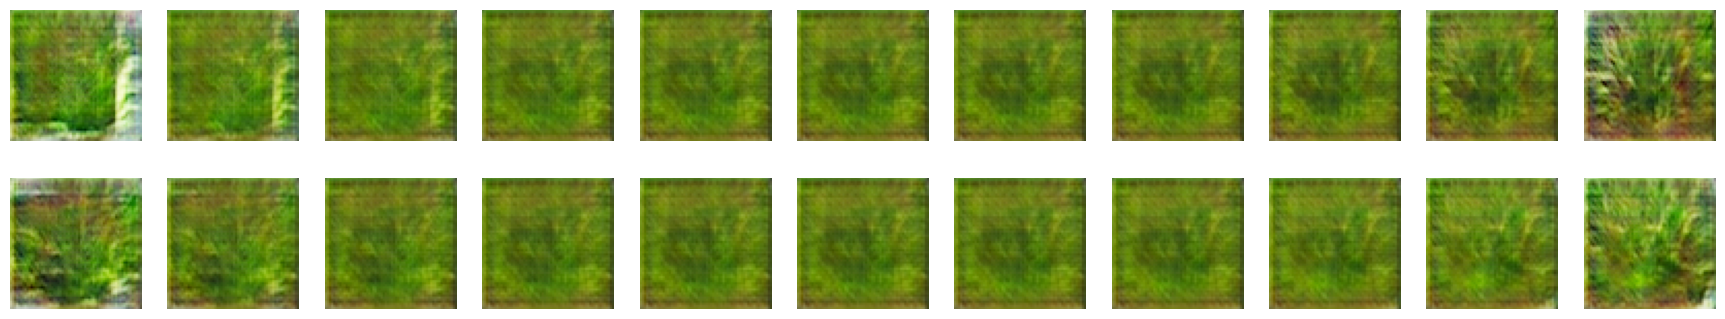

In [18]:
#=======================Manipulating input vector==============================
features = 32
preset = [-2, -1, -.5, -.2, -.1, 0, .1, .2, .5, 1, 2]

plt.figure(1, figsize=(2 * len(preset), features * 2))

i = 0
for feature in range(features):
    for value in preset:
        plt.subplot(features, len(preset), i+1)
        latent_vector = np.zeros((1, 32))
        latent_vector[0, feature] = value
        img = G.predict(latent_vector)[0]
        plt.imshow(img)
        plt.savefig(main_path + 'generated_images/' + 'controlled_shifts.png')
        plt.axis('off')
        i += 1
plt.show()

Load the saved model and Test Drive it

1/1 [==============================] - 0s 227ms/step


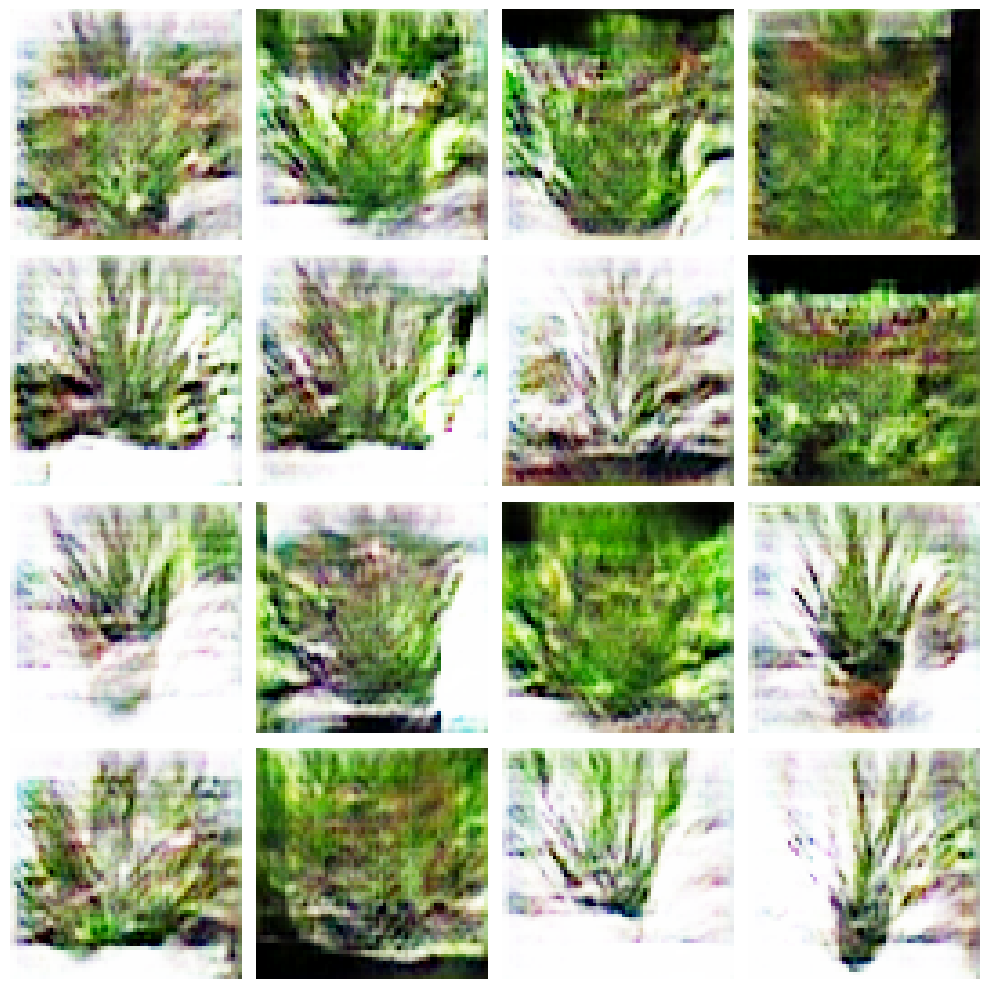

In [33]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Directly load the saved generator model
generator = load_model(main_path + 'trained_model/' + 'DCGAN_generator.keras')

# Generate images
def generate_and_plot_images(generator, num_images=16, dim=(4, 4), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[num_images, 32])  # Adjust according to your generator's input dimension
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, :], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_and_plot_images(generator)